# Analyzing Neural Time Series Data: Chapter 9
#### Converted from MATLAB to Python by Andrew J. Graves on 12/03/19

In [1]:
# Import modules
import numpy as np
from scipy import signal, interpolate
import matplotlib.pyplot as plt
from math import ceil
plt.rc('font', size=8)

# Run data extraction and useful function script
%run 'data_and_funcs.ipynb'

## Figure 9.1

<IPython.core.display.Javascript object>


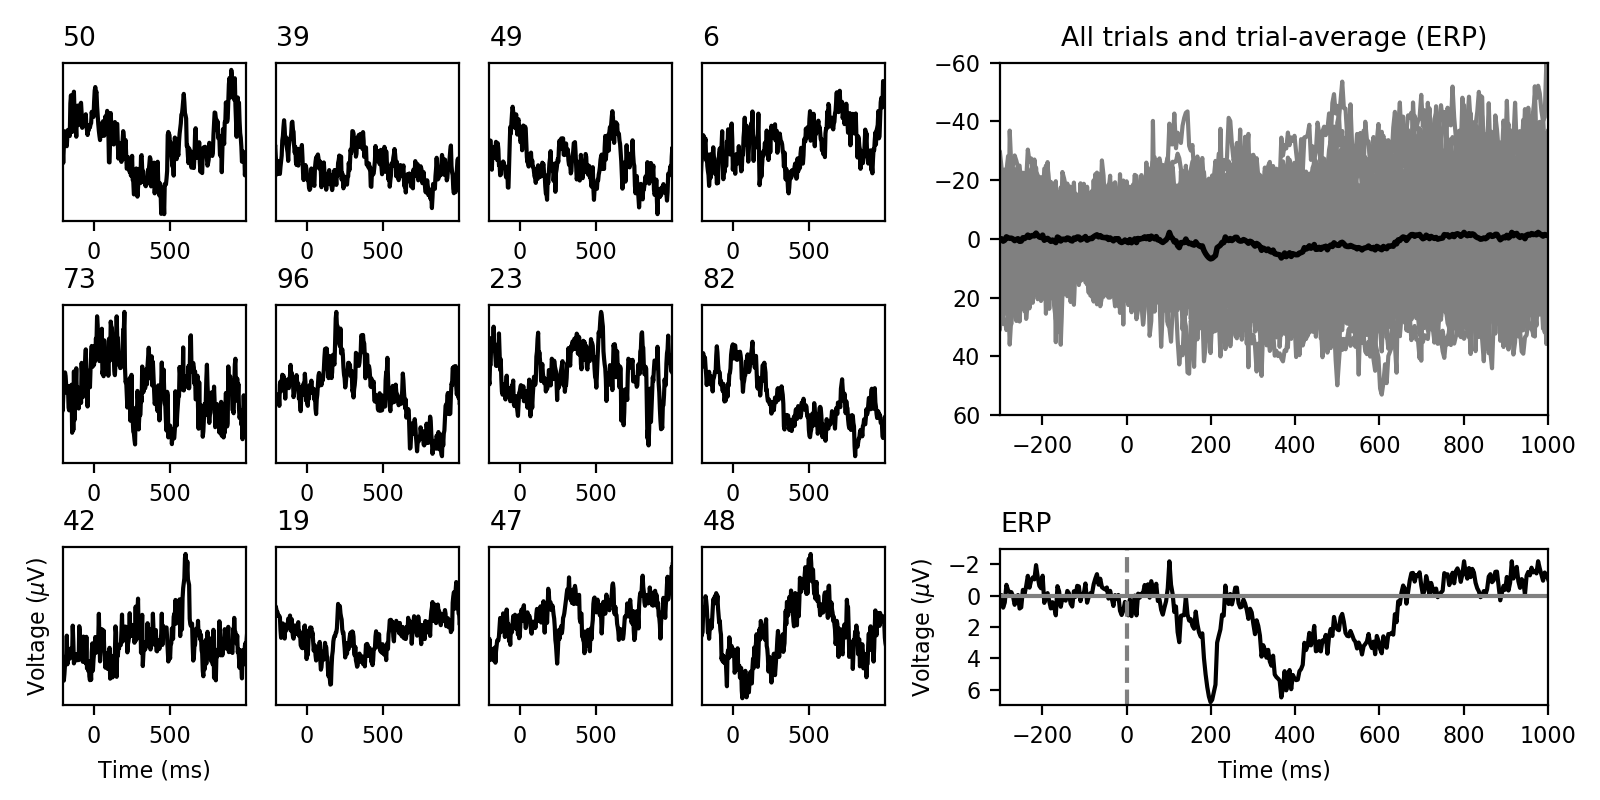

In [2]:
# Get matplotlib magick
%matplotlib notebook

# Specify channel label
which_chan = 'FCz'

# Find the index (channel number) of that label
chan_index = [index for index, item in enumerate(chan_names) if item == which_chan]

# Set up the figure and grid
fig_91 = plt.figure(figsize=(8, 4))
heights = [2.25, 1]
widths = [1.5, 1]
full_grid = fig_91.add_gridspec(nrows=2, ncols=2, height_ratios=heights, width_ratios=widths)

# Figure 9.1A ----------

# Determine the number of trials to plot, the total number of trials, and randomly select from available trials
num_trials_to_plot = 12
num_trials = eeg_data.shape[2]
random_trials_to_plot = np.random.permutation(num_trials)[0:12]

# Uncomment the following line if you would like to replicate Cohen's trials
# random_trials_to_plot = np.array([68, 74, 65, 70, 28, 10, 69, 95, 44, 76, 19, 45]) - 1

# Compute appropriate grid size for subplots
n_rows = ceil(num_trials_to_plot/ceil(np.sqrt(num_trials_to_plot)))
n_cols = ceil(np.sqrt(num_trials_to_plot))

# Set subgrid
grid_A = full_grid[0:, 0].subgridspec(n_rows, n_cols)

# Loop through random trials and plot them on the subgrid
j = 0
for i in random_trials_to_plot:

    ax_A = fig_91.add_subplot(grid_A[j])
    ax_A.plot(eeg_time, eeg_data[chan_index, :, i][0], color='black')
    ax_A.set_xlim([-200, 1000])
    ax_A.set_xticks([0, 500])
    ax_A.set_yticks([])
    ax_A.set_title(str(i + 1), loc='left')
    plt.tight_layout()
    
    # Label the bottom left corner subplot
    if j == (n_rows * n_cols - n_cols):
        ax_A.set_xlabel('Time (ms)')
        ax_A.set_ylabel(r'Voltage ($\mu$V)')
    j += 1
    
# Figure 9.1B ----------

ax_B = fig_91.add_subplot(full_grid[0, 1])
ax_B.plot(eeg_time, np.squeeze(eeg_data[chan_index, :, :]), color='gray')
ax_B.plot(eeg_time, get_erp(eeg_data, chan_index), color='black', linewidth=2)
ax_B.set_xlim([-300, 1000])
ax_B.set_ylim([-60, 60])
ax_B.invert_yaxis()
ax_B.set_title('All trials and trial-average (ERP)')

# Figure 9.1C ----------

ax_C = fig_91.add_subplot(full_grid[1, 1])
ax_C.plot(eeg_time, get_erp(eeg_data, chan_index), color='black')
ax_C.axhline(y=0, color='grey')
ax_C.axvline(x=0, color='grey', linestyle='dashed')
ax_C.set_xlim([-300, 1000])
ax_C.invert_yaxis()
ax_C.set_yticks([6, 4, 2, 0, -2])
ax_C.set_ylim([7, -3])
ax_C.set_xlabel('Time (ms)')
ax_C.set_ylabel(r'Voltage ($\mu$V)')
ax_C.set_title('ERP', loc='left')

fig_91.tight_layout(h_pad=2.5)
#fig_91.suptitle('Randomly selected single trials', x=.167, y=1)

## Figure 9.2

<IPython.core.display.Javascript object>


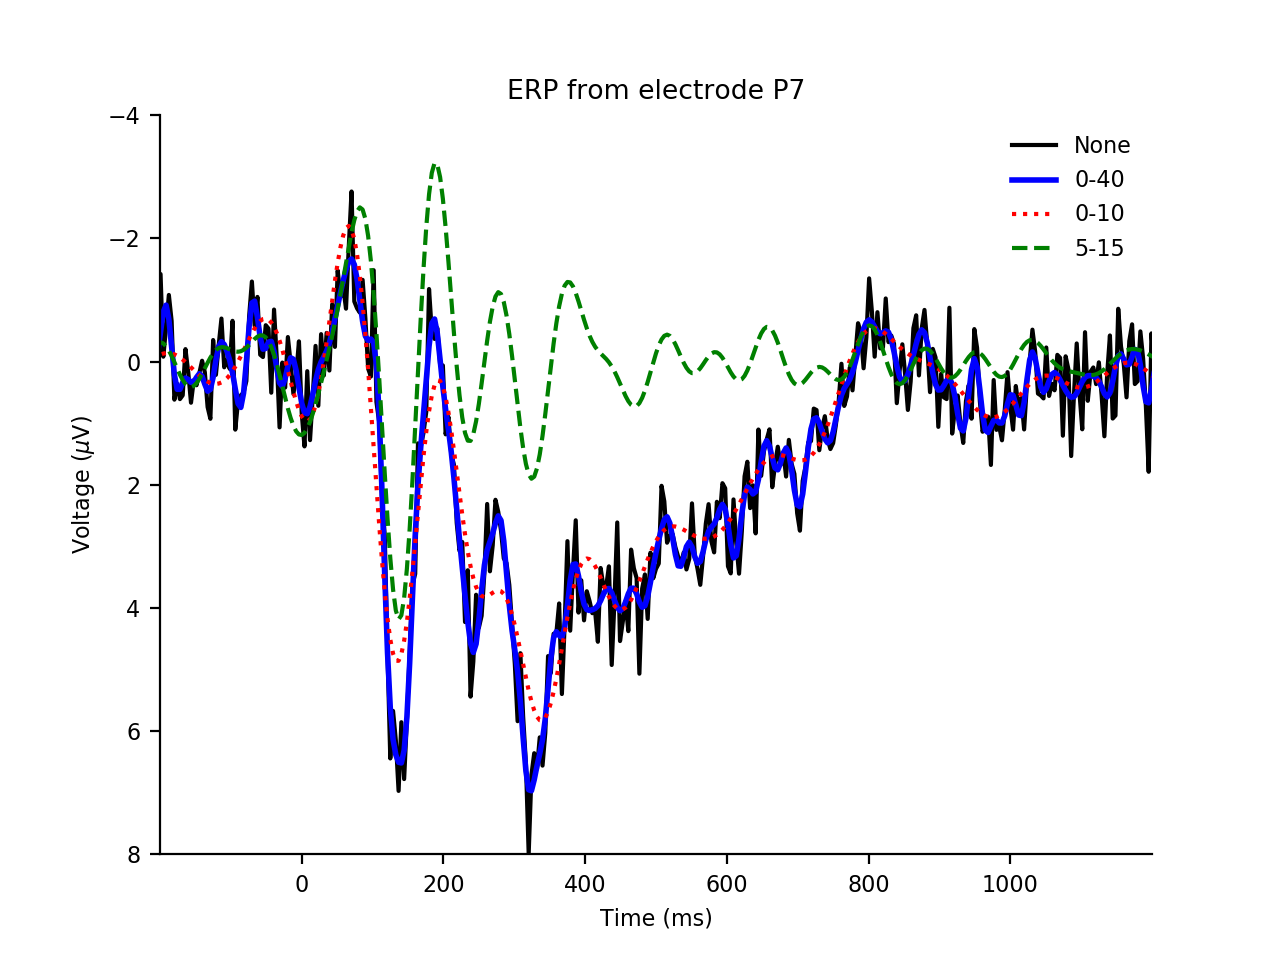

In [3]:
# Specify channel label
which_chan = 'P7'

# Find the index (channel number) of that label
p7_index = [index for index, item in enumerate(chan_names) if item == which_chan]

erp = get_erp(eeg_data, p7_index)

nyquist = samp_rate.item() / 2
transition_width = 0.15 # percentage

# Run a low-pass filter from 0 to 40 Hz
erp_0_to_40 = low_pass_erp(erp, filter_cutoff=40, trans_width=transition_width, nyq=nyquist)

# Run a low-pass filter 0 to 10 Hz
erp_0_to_10 = low_pass_erp(erp, filter_cutoff=10, trans_width=transition_width, nyq=nyquist)

# Run a band-pass filter from 5 to 15 Hz
erp_5_to_15 = band_pass_erp(erp, filter_low=5, filter_high=15, trans_width=transition_width, nyq=nyquist)

# Figure 9.2 ----------

fig, ax = plt.subplots()
ax.plot(eeg_time, erp, linestyle='solid', color='black')
ax.plot(eeg_time, erp_0_to_40, linewidth=2, color='blue')
ax.plot(eeg_time, erp_0_to_10, linestyle=':', color='red')
ax.plot(eeg_time, erp_5_to_15, linestyle='--', color='green')
ax.set_xlim([-200, 1200])
ax.set_xticks([0, 200, 400, 600, 800, 1000])
ax.invert_yaxis()
ax.set_yticks([8, 6, 4, 2, 0, -2, -4])
ax.set_xlabel('Time (ms)')
ax.set_ylabel(r'Voltage ($\mu$V)')
ax.set_title('ERP from electrode ' + which_chan)
ax.legend(loc='upper right', labels=('None', '0-40', '0-10', '5-15'), frameon=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

## Figure 9.3

<IPython.core.display.Javascript object>


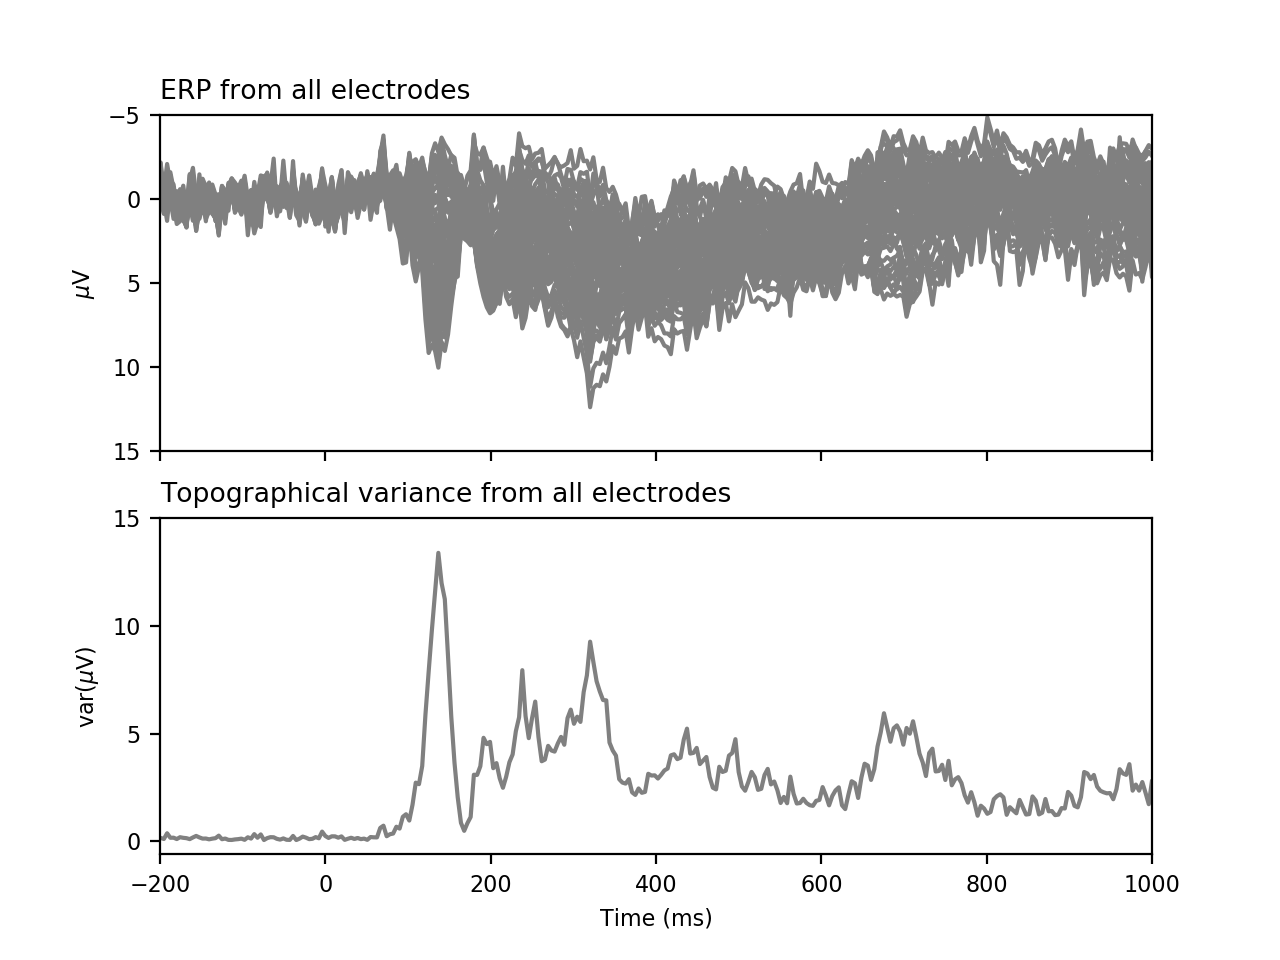

In [4]:
# Prepare the subplots
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)

# Axis 1
for i in np.arange(eeg_data.shape[0]):
    ax1.plot(eeg_time, np.mean(eeg_data[i, :, :], 1), color="gray")
ax1.invert_yaxis()
ax1.set_ylim([15, -5])
ax1.set_ylabel(r'$\mu$V')
ax1.set_title('ERP from all electrodes', loc='left')

# Axis 2
ax2.plot(eeg_time, np.var(np.mean(eeg_data, 2), 0), color="gray")
ax2.set_xlim([-200, 1000])
ax2.set_yticks([0, 5, 10, 15])
ax2.set_xlabel('Time (ms)')
ax2.set_ylabel(r'var($\mu$V)')
ax2.set_title('Topographical variance from all electrodes', loc='left')
plt.show()

## Figure 9.4

First, we need to get the grids to plot the topography.

<IPython.core.display.Javascript object>


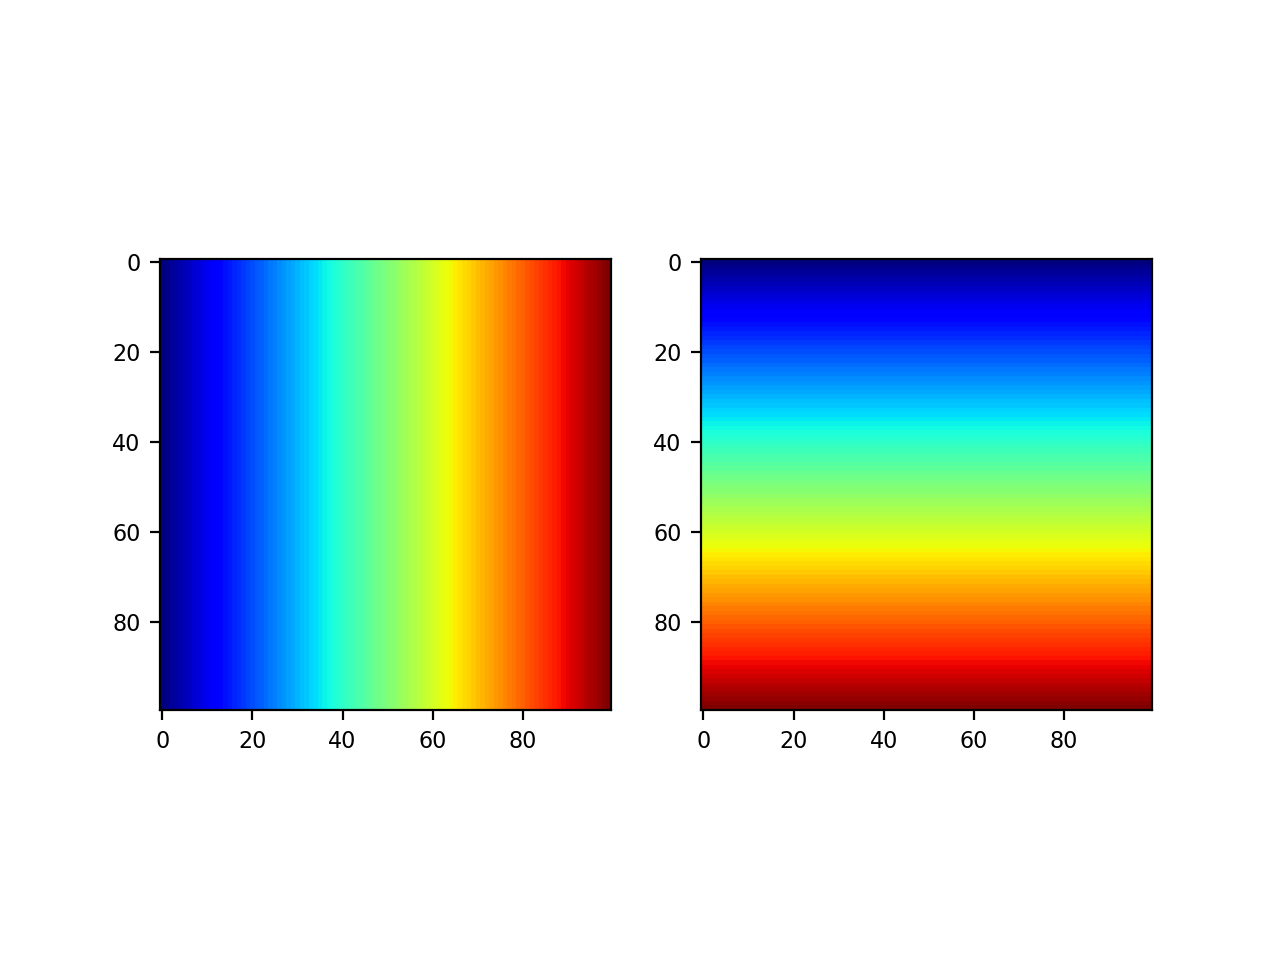

In [5]:
time_point_to_plot = 100
trial_to_plot = np.random.randint(eeg_data.shape[2] + 1)
color_limit = 20
interp_level = 100

abs_times = np.abs(eeg_time - time_point_to_plot)
junk = np.min(abs_times)
min_idx = np.where(abs_times == abs_times.min())

# May wanna move some of this manip to parent script
th = (np.pi / 180 * EEG['chanlocs'].item()['theta']).tolist()
elec_locs_x, elec_locs_y = pol_to_cart(th, EEG['chanlocs'].item()['radius'].tolist())

interp_x = np.linspace(np.min(elec_locs_x), np.max(elec_locs_x), interp_level)
interp_y = np.linspace(np.min(elec_locs_y), np.max(elec_locs_y), interp_level)
grid_x, grid_y = np.meshgrid(interp_x, interp_y)

# Plot the grids
fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.imshow(grid_x, cmap='jet')
ax2.imshow(grid_y, cmap='jet')
plt.show()

<IPython.core.display.Javascript object>


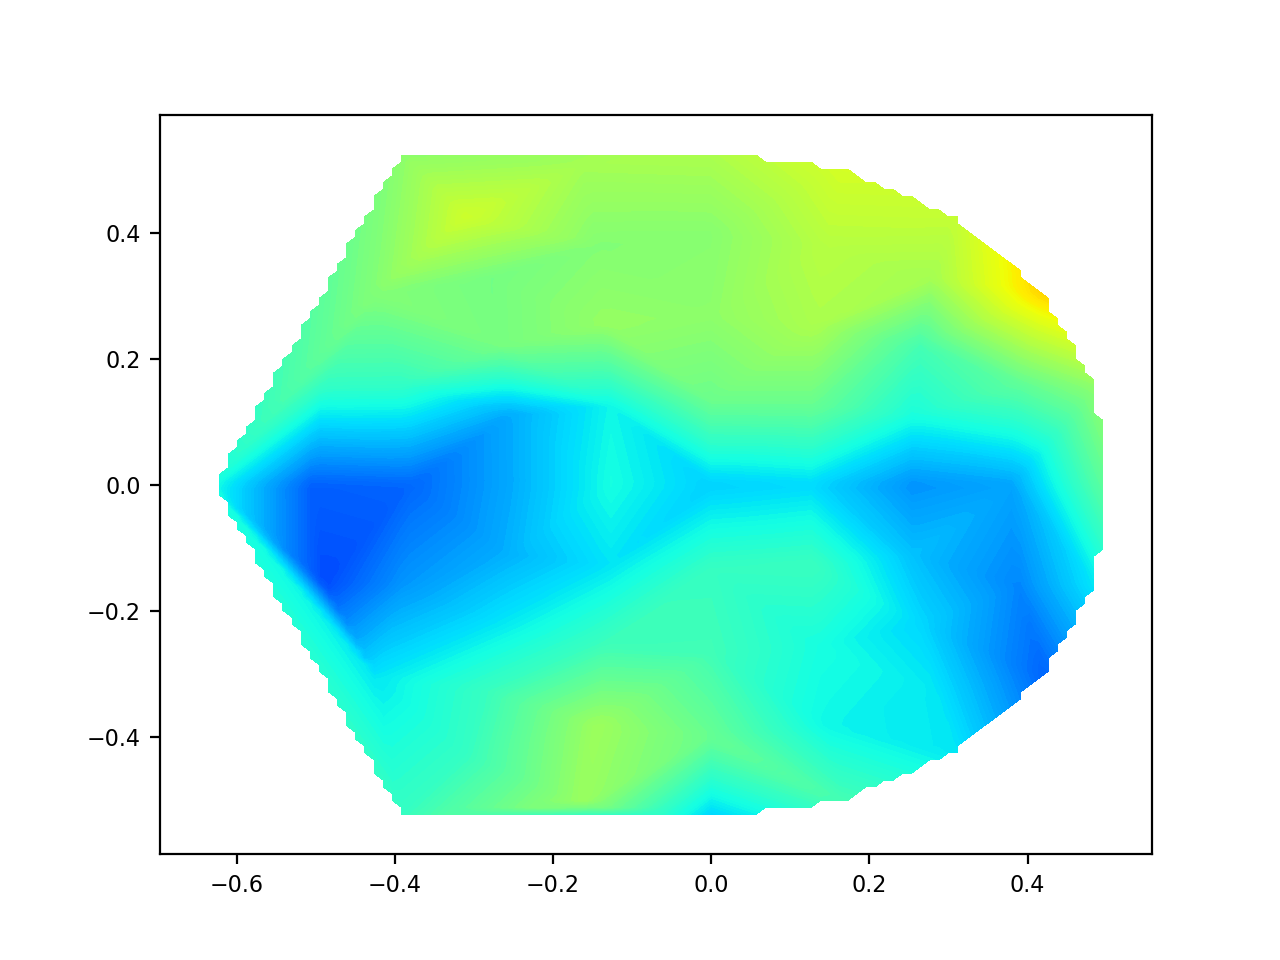

In [6]:
# Replicate MATLAB
trial_to_plot = 26
topo_data = np.squeeze(eeg_data[:, min_idx, trial_to_plot])
                       
interp_eeg_data = interpolate.griddata(np.squeeze(np.c_[elec_locs_x, elec_locs_y]), 
                                       topo_data, 
                                       (grid_x, grid_y))

# Plot
fig, ax = plt.subplots(ncols=1)
ax.contourf(interp_x, interp_y, interp_eeg_data, 100, vmin=-color_limit, vmax=color_limit, cmap='jet')
ax.set_xlim(np.min(interp_x) * 1.1, np.max(interp_x) * 1.1)
ax.set_ylim(np.min(interp_y) * 1.1, np.max(interp_y) * 1.1)
plt.show()

<IPython.core.display.Javascript object>


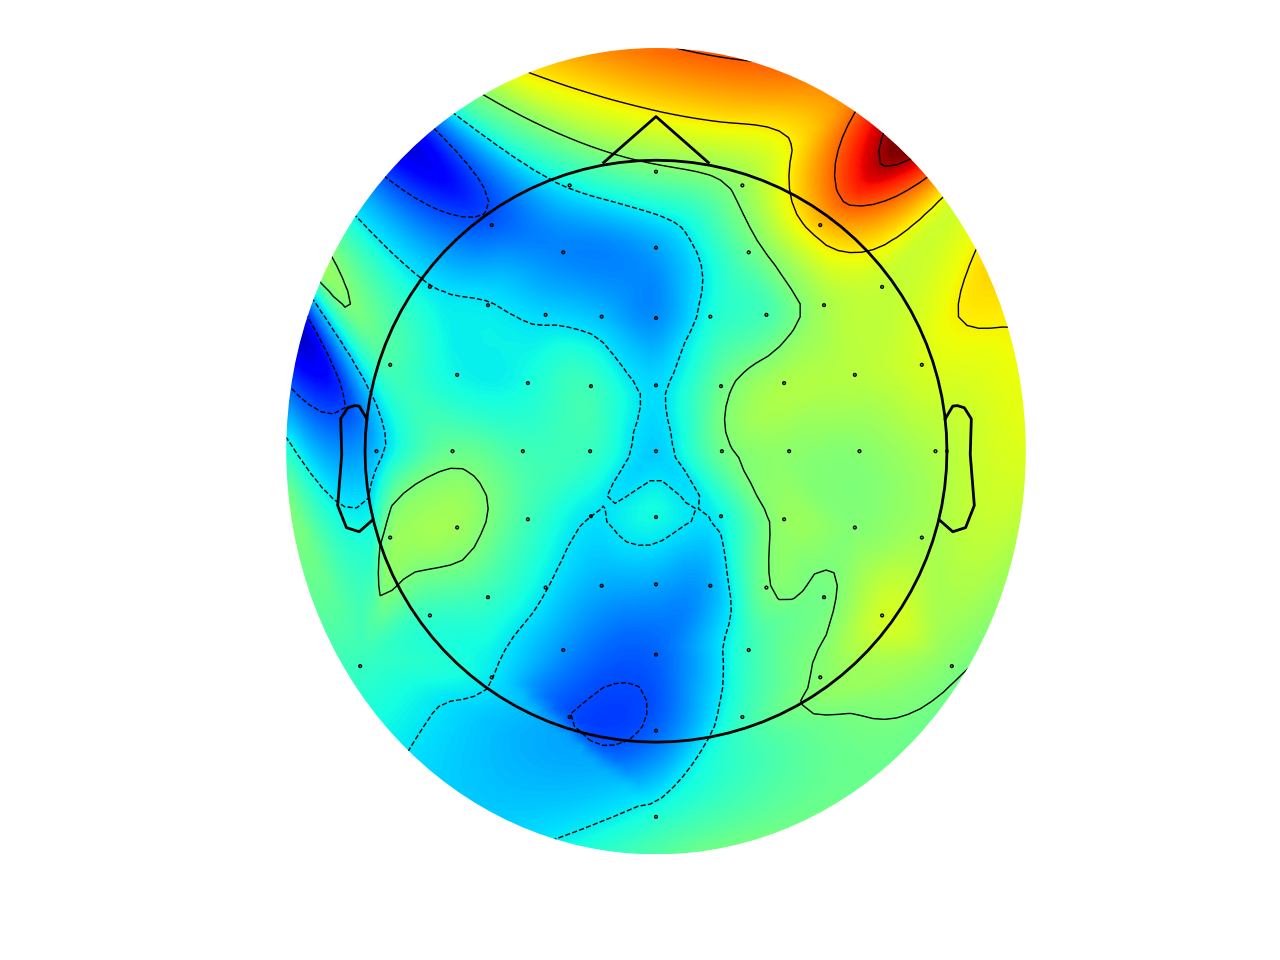

In [7]:
head_dict = {'center': [0, 0], 
             'scale': [.4, .4]}

plt.figure()
mne.viz.plot_topomap(topo_data, info, 
                     vmin=-color_limit, vmax=color_limit, cmap='jet',
                     outlines='skirt', 
                     contours = 8,
                     head_pos = head_dict
                     )
plt.show()
# Need to finish Figure 9.4!

## Figure 9.5

<IPython.core.display.Javascript object>


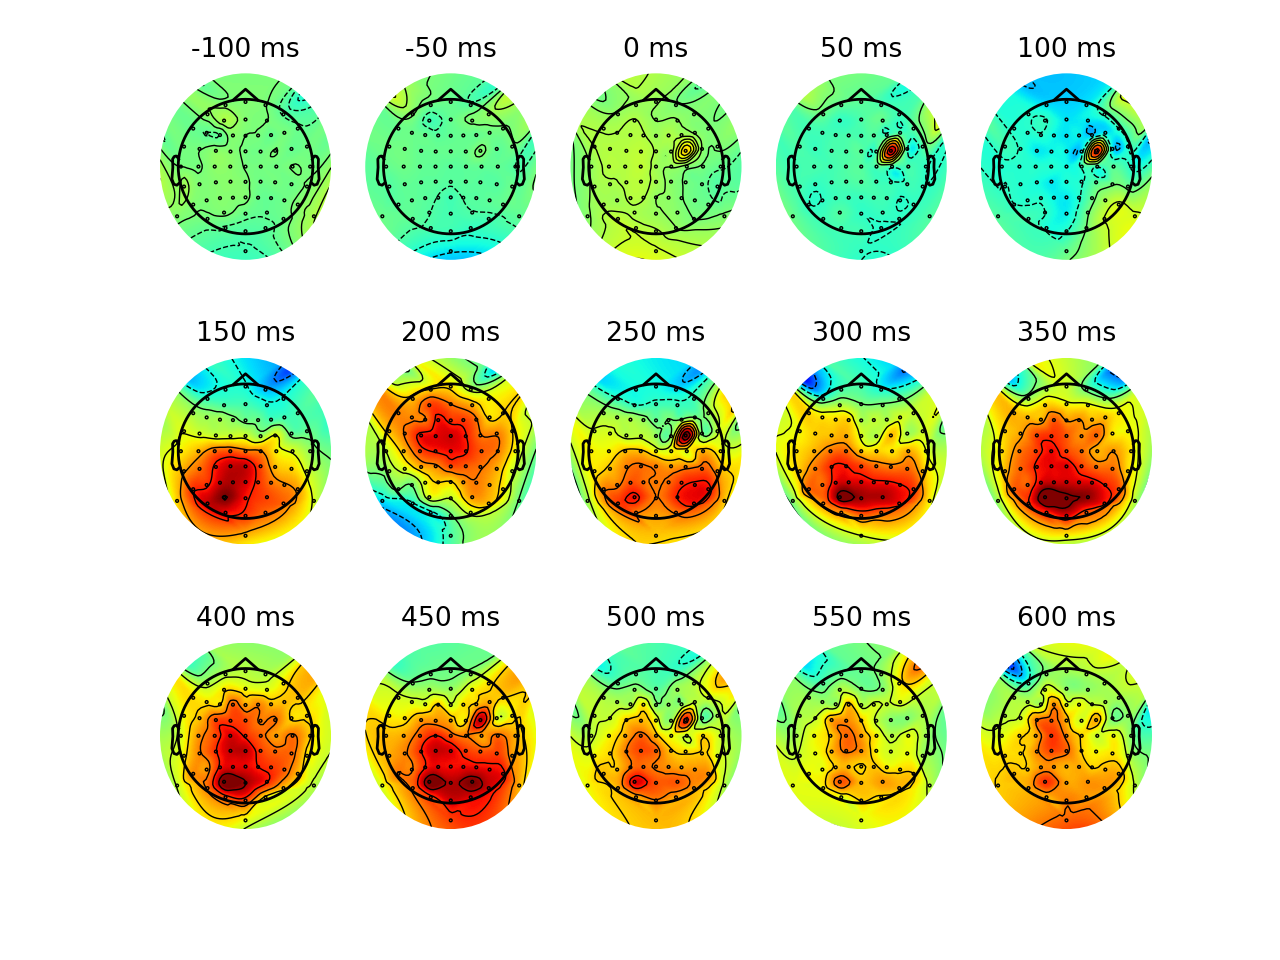

In [8]:
# Find the times in the EEG closest to the numbers in the sequence from -100 to 600 with step size of 50
times_to_plot = []
for i in np.arange(-100, 650, 50):
    times_to_plot.append(np.abs(eeg_time - i).argmin())

# Set up the grid
fig_95 = plt.figure()
full_grid = fig_95.add_gridspec(nrows=3, ncols=5)
# Find the index for FC4
fc4_index = [index for index, item in enumerate(chan_names) if item == 'FC4']

# Iterate through the different times and plot the data averaged over trials
for i in np.arange(len(times_to_plot)):
    eeg_data_plot = np.squeeze(np.mean(eeg_data[:, times_to_plot[i], :], 1))
    eeg_data_plot[fc4_index] = np.random.random() * 10
    
    
    ax = fig_95.add_subplot(full_grid[i])
    mne.viz.plot_topomap(eeg_data_plot, info, 
                     vmin=-8, vmax=8, cmap='jet',
                     outlines='skirt', 
                     contours = 8,
                     head_pos = head_dict
                     )
    
    ax.set_title(np.array2string(np.arange(-100, 650, 50)[i]) + ' ms')

## Figure 9.6

<IPython.core.display.Javascript object>


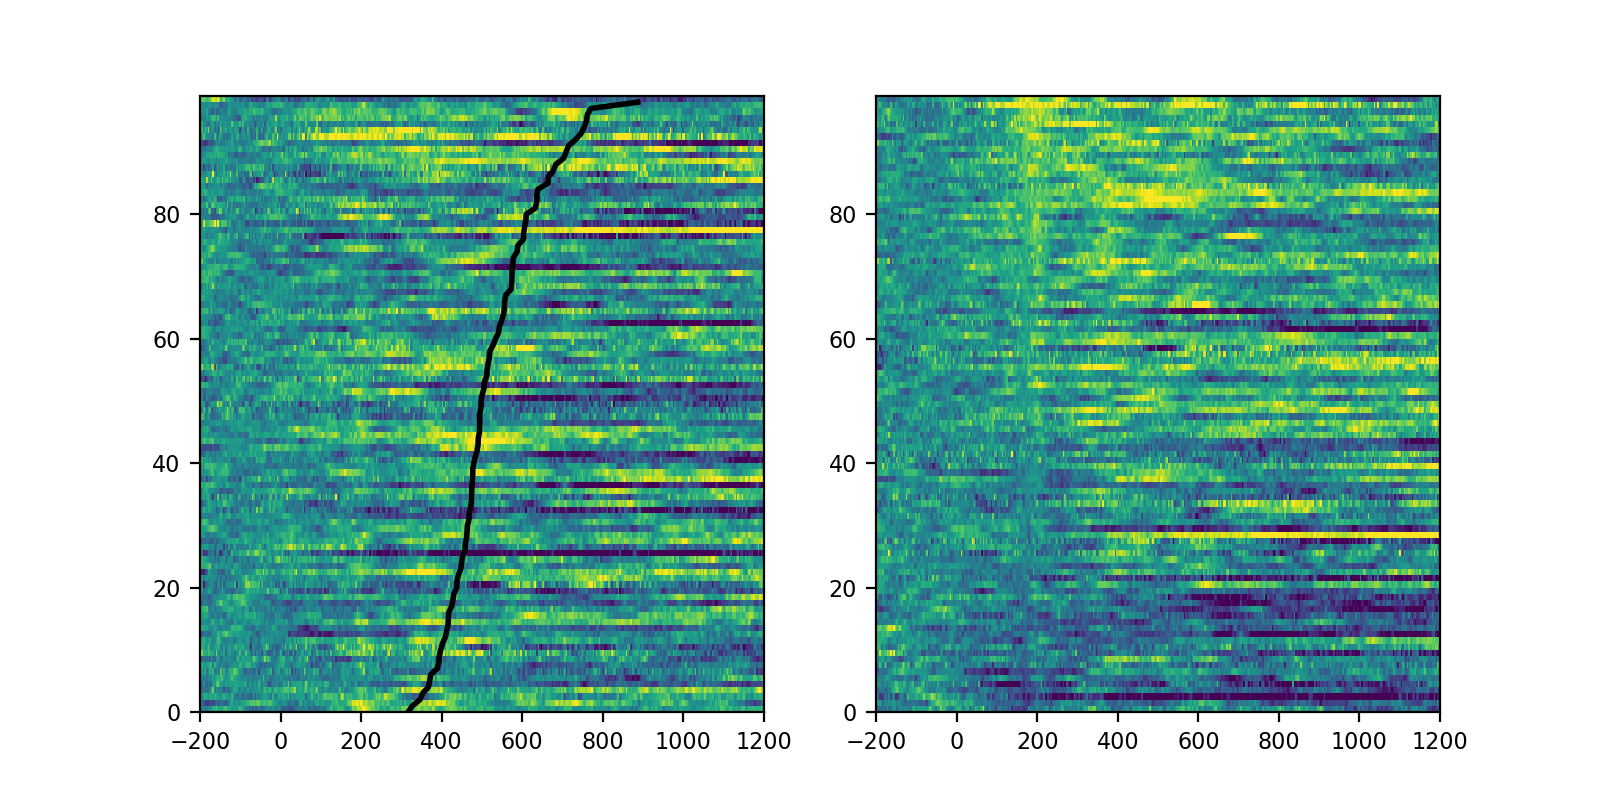

In [9]:
rts = np.zeros(eeg_data.shape[2])

for i in np.arange(len(rts)):
    time_0_ev = np.where(np.concatenate(EEG['epoch'].item()[0 , i]['eventlatency'] == 0))
    rts[i] = np.concatenate(EEG['epoch'].item()[0 , i]['eventlatency'])[time_0_ev[0] + 1]
    
fig, ax = plt.subplots(ncols=2, figsize=[8, 4])
for i in np.arange(2):
    if i == 0:
        sort_idx = np.argsort(rts)
        ax[0].plot(rts[sort_idx], np.arange(len(rts)), color='black', linewidth=2)
    else:
        sort_idx = np.argsort(np.squeeze(eeg_data[chan_index, 300, :]))
       
    ax[i].imshow(np.squeeze(eeg_data[chan_index, :, sort_idx]), 
           extent=[np.min(eeg_time), np.max(eeg_time), len(rts), 0],
           aspect='auto', vmin=-30, vmax=30)
    ax[i].set_xlim([-200, 1200])
    ax[i].invert_yaxis()

In [10]:
# Need to format all the plots!!! 